# Quantum linear system solver

One use of the quantum phase estimation algorithm is to solve systems of linear equations, as first proposed in the famous [HHL algorithm](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502) as will be discussed in this section. The goal of this algorithm is that given $N\times N$ matrix $A$ and vector $\mathbf{b}$ of length $N$ to find vector $\mathbf{x}$ such that:

$$ A\mathbf{x} = \mathbf{b}. $$

Classically, this would typically involve calculating $A^{-1}$ and calculating $A^{-1}\mathbf{b}$ with a complexity of $O(N^{k})$ where $k$ lies between $2-3$.

The HHL algorithm looks to solve an analogous quantum problem where we have a state $|b\rangle$ of $n$ qubits and a $2^n \times 2^n$ unitary operator $\hat{A}$ where we wish to prepare the state $|x\rangle$ such that:

$$ \hat{A}|x\rangle = |b\rangle. $$

At this point it is worth emphasising that, like the comparison between the quantum Fourier transform and the classical discrete Fourier transform, the classical and quantum linear system problems are distinctly different, and require different algorithms to solve. 

The HHL algorithm is performed in four steps:

   1. Prepare state $|b\rangle=\sum^{2^{n}-1}_{j=0}\beta_{j}|u_j\rangle$ on a register of $n$ qubits where $u_j$ are the eigenbases of $A$ and coefficients $\beta_j$.
   
   2. Apply quantum phase estimation algorithm to estimate the eigenvalues of $A$ given $|b\rangle$ and save the result to a second ancillary register of $n_{out}$ qubits to produce state:
   
   $$ \sum^{2^{n}-1}_{j=0}\beta_j|u_j\rangle|\lambda_j\rangle, $$
   
   where $\lambda_j$ are the eigenvalues of $A$ corresponding to the eigenbases $u_j$.
   
   3. Introduce a third register of a single qubit and perform a rotation on this target qubit controlled on the second register to produce the state:
   
   $$ \sum^{2^{n}-1}_{j=0}\beta_j|u_j\rangle|\lambda_j\rangle\left(\sqrt{1-(c\lambda_{j}^{-1})^2}|0\rangle + c\lambda_{j}^{-1}|1\rangle\right). $$
   
   4. Apply the inverse quantum phase estimation algorithm to un-calculate the operation of step 2. to prepare the final state:
   
   $$ \sum^{2^{n}-1}_{j=0}\left(\sqrt{1-(c\lambda_{j}^{-1})^2}\beta_j|0\rangle + c\lambda_{j}^{-1}\beta_j|1\rangle\right)|\lambda_j\rangle. $$
   
The state resulting from step 4., if the target qubit is measured in the state $|1\rangle$, the initial register is left in the (unnormalised) state:

$$ \sum^{2^{n}-1}_{j=0}\lambda_{j}^{-1}\beta_j|\lambda_j\rangle=\hat{A}^{-1}|b\rangle, $$

as desired. Let us now use the quantum phase estimation from the previous notebook to perform the HHL algorithm.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import ExactReciprocal
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import random_hermitian
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
def HHL(circ, qreg, qanc, qtarg, A, t=2.*np.pi, scaling=None, wrap=False, inverse=False, neg_vals=True, label='HHL'):
        
    n = len(qreg)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qreg = QuantumRegister(n, 'q_reg')
        qanc = QuantumRegister(nanc, 'q_anc')
        qtarg = QuantumRegister(1, 'q_targ')
        circ = QuantumCircuit(qreg, qanc, qtarg)

    A_gate = HamiltonianGate(A, t)
        
    qe_gate = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate, [*qreg, *qanc]);
        
    rec_gate = ExactReciprocal(nanc, scaling=scaling, neg_vals=neg_vals).to_gate()
    circ.append(rec_gate, [*qanc[::-1], qtarg]);

    qe_gate_inv = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, inverse=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate_inv, [*qreg, *qanc]);
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

In [4]:
n = 2

In [5]:
A = random_hermitian(2**n).to_matrix()
print(A)

[[ 0.38637889+0.j          0.49095715-0.75532632j  0.27257681+0.25020569j
  -0.70443521+0.02068663j]
 [ 0.49095715+0.75532632j -2.03395164+0.j         -0.0321368 -0.9525803j
   0.96362389+0.21991644j]
 [ 0.27257681-0.25020569j -0.0321368 +0.9525803j   0.61085828+0.j
  -1.00643899+0.95283291j]
 [-0.70443521-0.02068663j  0.96362389-0.21991644j -1.00643899-0.95283291j
  -0.25717796+0.j        ]]


In [6]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [7]:
phase = True

lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))
kappa = np.abs(lambda_max/lambda_min)

# Choose a sucess probability of determining 
p_suc = 0.99
# Determine the number of ancillary
nanc = n + int(np.ceil(np.log2(2. + 1./(2.*(1-p_suc)))))

# Calculate the new scale of the relative magnitudes of maximum and minimum eigenvalues
rescale = int((2**(nanc-phase)-1)/kappa)
# Make sure this scaling is not vanishingly small
if rescale < 1.e-7:
    rescale = 1
    
# determine the number of integer qubits required
nint = qt.get_nint(rescale)
# Assert that the number of integer qubits is equal to or greater than the number of ancillary qubits assigned
if nint < nanc - phase:
    nint = nanc - phase

scaling = qt.bin_to_dec(qt.my_binary_repr(rescale, nint=nint, n=nint, phase=False), nint=0, phase=False)#get_delta(nanc - phase, lambda_min, lambda_max)
t0 = scaling / (lambda_min * (2**phase))
t = 2 * np.pi * t0

print(t, scaling, nanc, kappa, lambda_min, lambda_max)

1.0360319049844795 0.21875 8 4.397493950994111 0.663322615516423 2.9169571892910624


In [8]:
qreg = QuantumRegister(n, 'q_reg')
circ = QuantumCircuit(qreg)

In [9]:
circ.h(qreg);

In [10]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
in_vector = np.asarray(result.get_statevector())

In [11]:
print(in_vector)

[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


In [12]:
qanc = QuantumRegister(nanc, 'q_anc')
qtarg = QuantumRegister(1, 'q_targ')

circ.add_register(qanc, qtarg)

In [13]:
circ = HHL(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling)

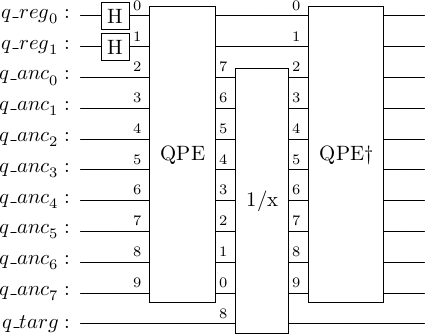

In [14]:
circ.draw('latex')

In [15]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [16]:
state_v = np.asarray(state_vector).reshape((2**1,2**nanc,2**n))

In [17]:
# 1, nanc, n
print(state_v.shape)

(2, 256, 4)


In [18]:
norm_ = np.sqrt(np.sum(np.abs(state_v[1])**2))
print(norm_)

0.7211800976291101


In [19]:
state_v = state_v[1,0]

In [20]:
print(state_v)

[ 0.43625394-0.27800909j  0.10039578+0.05151897j -0.11915875+0.36069081j
 -0.27632781-0.13420069j]


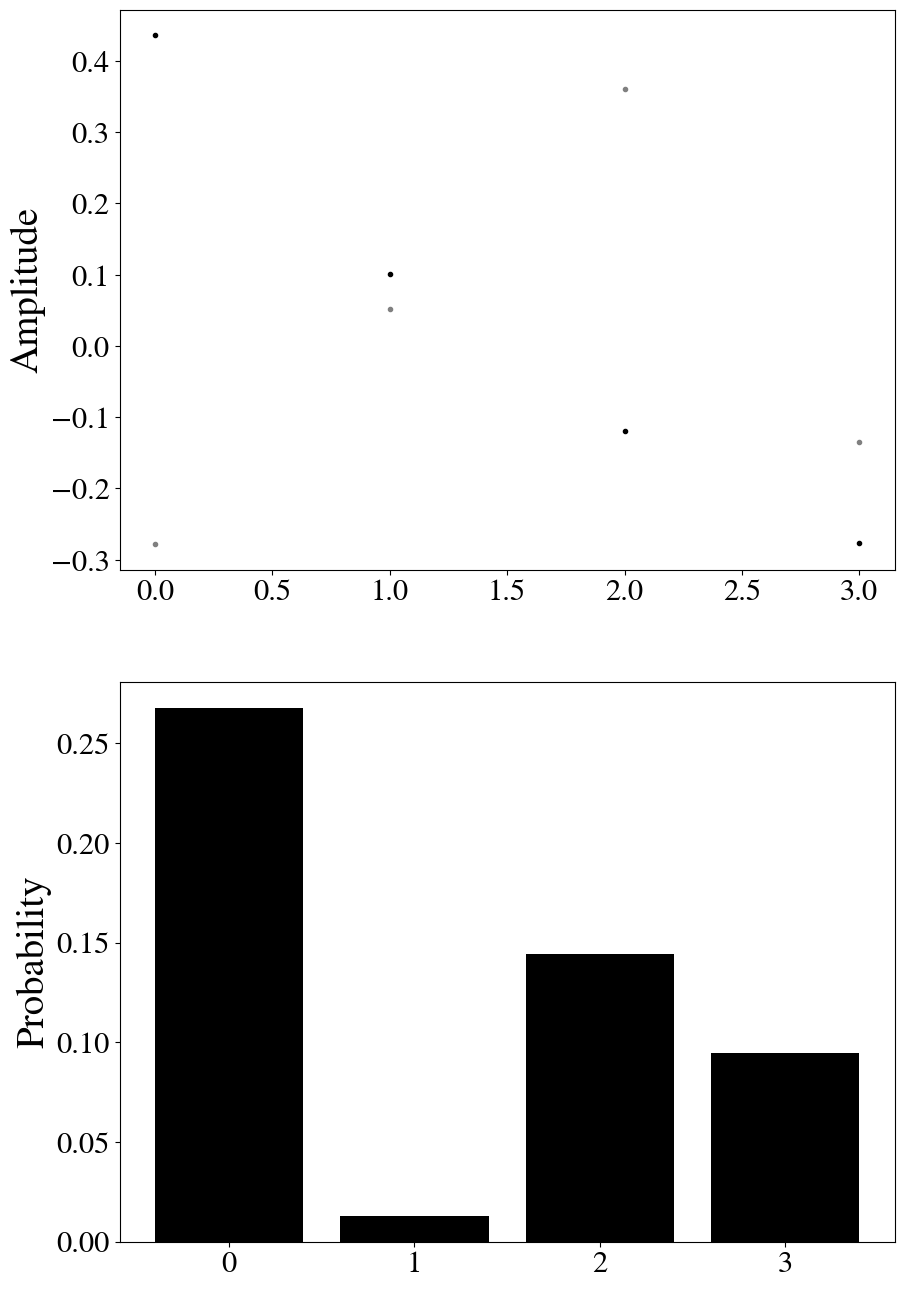

In [21]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
plt.scatter(np.arange(2**n), state_v.imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.bar(np.arange(2**n), np.abs(state_v)**2, color='black')
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [22]:
state_v = state_v.real/np.sqrt(np.sum(np.abs(state_v)**2))

In [23]:
targ = np.matmul(np.linalg.inv(A),in_vector).real

In [24]:
norm = norm_/lambda_min

In [25]:
out = state_v*norm

In [26]:
print(out, targ)

[ 0.65837465  0.15151275 -0.17982897 -0.41702139] [ 0.65739001  0.15036164 -0.18132416 -0.419103  ]


In [27]:
out/targ

array([1.0014978 , 1.00765559, 0.99175407, 0.99503318])